In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

with open("BalticDryIndexDataset.npy", 'rb') as f:
    (feature_train, target_train), (feature_test, target_test) = pickle.load(f)

print(feature_train.shape, target_train.shape) # (861, 6) (861, 1)
print(feature_test.shape, target_test.shape) # (99, 6) (99, 1)

(861, 13) (861, 1)
(99, 13) (99, 1)


In [4]:
print(torch.__version__)

0.4.1


In [2]:
def standard_scaler(train, test):
    assert train.shape[-1] == test.shape[-1], "invalid channel size"
    
    # trainでmeanとstdを決める
    for c in range(train.shape[-1]):
        mean = np.mean(train[:,c])
        std = np.std(train[:,c])
        train[:,c] = (train[:,c] - mean) / std
        test[:,c] = (test[:,c] - mean) / std
    
    return train, test

feature_train, feature_test = standard_scaler(feature_train, feature_test)
target_train,  target_test  = standard_scaler(target_train,  target_test)

print(feature_train.shape, target_train.shape) # (861, 6) (861, 1)
print(feature_test.shape, target_test.shape) # (99, 6) (99, 1)

(861, 13) (861, 1)
(99, 13) (99, 1)


In [3]:
train_divisions = np.arange(len(feature_train)-31, 0, -30)[::-1][1:] # 最後の端数21は短すぎるから無視。
test_divisions = np.arange(len(feature_train)-1,len(feature_train)+len(feature_test)-30, 1)

# -------- 可視化(?)
print("d, input, output")
print("\n---- train ----")
[print(str(d)+", 0~"+str(d)+", "+str(d+1)+"~"+str(d+30)) for d in train_divisions]
print("\nlen(train_divisions) :", len(train_divisions))
print("\n---- test ----")
[print(str(d)+", 0~"+str(d)+", "+str(d+1)+"~"+str(d+30)) for d in test_divisions[:5]]
print(" ~ ")
[print(str(d)+", 0~"+str(d)+", "+str(d+1)+"~"+str(d+30)) for d in test_divisions[-5:]]
print("\nlen(test_divisions) :", len(test_divisions))
print("")

d, input, output

---- train ----
50, 0~50, 51~80
80, 0~80, 81~110
110, 0~110, 111~140
140, 0~140, 141~170
170, 0~170, 171~200
200, 0~200, 201~230
230, 0~230, 231~260
260, 0~260, 261~290
290, 0~290, 291~320
320, 0~320, 321~350
350, 0~350, 351~380
380, 0~380, 381~410
410, 0~410, 411~440
440, 0~440, 441~470
470, 0~470, 471~500
500, 0~500, 501~530
530, 0~530, 531~560
560, 0~560, 561~590
590, 0~590, 591~620
620, 0~620, 621~650
650, 0~650, 651~680
680, 0~680, 681~710
710, 0~710, 711~740
740, 0~740, 741~770
770, 0~770, 771~800
800, 0~800, 801~830
830, 0~830, 831~860

len(train_divisions) : 27

---- test ----
860, 0~860, 861~890
861, 0~861, 862~891
862, 0~862, 863~892
863, 0~863, 864~893
864, 0~864, 865~894
 ~ 
925, 0~925, 926~955
926, 0~926, 927~956
927, 0~927, 928~957
928, 0~928, 929~958
929, 0~929, 930~959

len(test_divisions) : 70



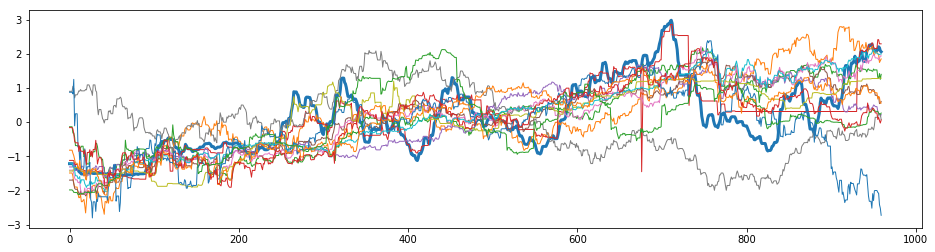

In [41]:
feature = np.concatenate([feature_train, feature_test], 0)
target = np.concatenate([target_train, target_test], 0)
plt.figure(figsize=(16,4)); plt.plot(target, linewidth=3); plt.plot(feature, linewidth=1);
# [plt.axvline(x) for x in train_divisions]; plt.axvline(861, c='r'); plt.show()

In [5]:
feature[1]

array([-1.48942726, -0.13622646, -1.12078372, -1.31207116, -1.69783306,
       -1.40603558,  0.90118865, -1.4322631 , -1.2008804 ,  0.87470496,
       -0.82204867, -1.98578759, -0.16098262])

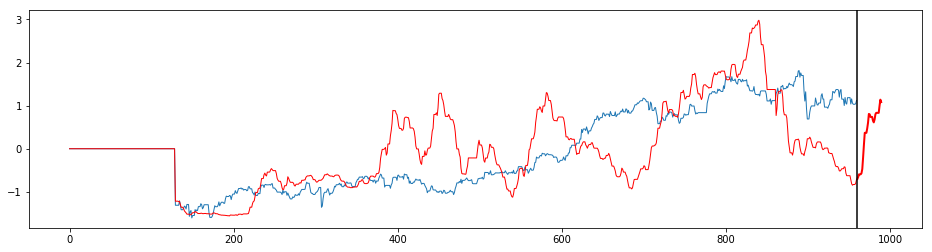

(960, 14) (30, 1)


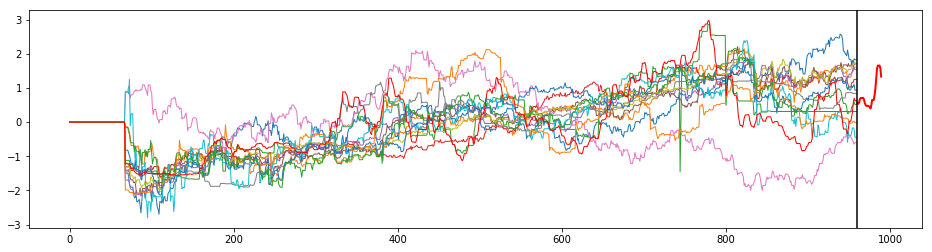

(960, 14) (30, 1)


In [6]:
def make_dataset(feature, target, divisions):
    X = []
    Y = []
    for d in divisions:
        X.append(np.concatenate([np.zeros([959-d,14]), np.concatenate([target[0:d+1], feature[0:d+1]], 1)], 0))
        Y.append(target[d+1:d+31]) # 長さ30で固定
    return X, Y

x_train, y_train = make_dataset(feature, target, train_divisions)
x_test, y_test = make_dataset(feature, target, test_divisions)

k = np.random.randint(len(x_train))
l = len(x_train[k])
plt.figure(figsize=(16,4))
plt.plot(x_train[k][:,4], linewidth=1);
plt.plot(x_train[k][:,0], linewidth=1, c='r');
plt.plot(np.arange(l, l+30), y_train[k], c='r', linewidth=2)
plt.axvline(l-0.5, c='k'); plt.show()
print(x_train[k].shape, y_train[k].shape)

k = np.random.randint(len(x_test))
l = len(x_test[k])
plt.figure(figsize=(16,4))
plt.plot(x_test[k][:,1:], linewidth=1);
plt.plot(x_test[k][:,0], linewidth=1, c='r');
plt.plot(np.arange(l, l+30), y_test[k], c='r', linewidth=2)
plt.axvline(l-0.5, c='k'); plt.show()
print(x_test[k].shape, y_test[k].shape)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# TODO: LSTMCell使う
class Model(nn.Module):
    def __init__(self, input_size=14, hidden_size=256, output_size=14):
        self.hidden_size = hidden_size
        
        super(Model, self).__init__()
        self.lstm = nn.LSTMCell(input_size=input_size,
                            hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, input_size) # -> 7
        
    def forward(self, input, l_pre, l_post):
        h_n = torch.zeros(len(input), self.hidden_size) # Nx256
        c_n = torch.zeros(len(input), self.hidden_size) # Nx256 cell
        output = []
        
        for k in range(l_pre):
            i_n = input[:,k,:] # batch_size N, T, features # Nxlen(features)
            h_n, c_n = self.lstm(i_n, (h_n, c_n)) # Nx7, Nx256, Nx256 -> Nx256, Nx256
        
        o_n = i_n+self.fc(h_n) # Nx256 -> Nx7
        
        for k in range(l_pre,l_pre+l_post):
            i_n = o_n
            h_n, c_n = self.lstm(i_n, (h_n, c_n)) # Nx7, Nx256, Nx256 -> Nx256, Nx256
            o_n = i_n+self.fc(h_n) # Nx256 -> Nx7
            output.append(o_n[:,0:1])
            
        return torch.stack(output).transpose(0,1) # 30,N,1 -> N,30,1

In [8]:
class BalticDryIndexDataset(Dataset):
    def __init__(self, X, Y):
        self.X = np.array(X, np.float32)
        self.Y = np.array(Y, np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [9]:
# model = Model(1, 8, 1)
# data_loader = DataLoader(SinDataset(), batch_size=10, shuffle=True)
# x,_ = iter(data_loader).next()
# print(x.shape)
# output, hidden, cell = model(x)
# output.shape, hidden.shape, cell.shape

In [10]:
model = Model(input_size=14, hidden_size=256, output_size=14)
data_loader = DataLoader(BalticDryIndexDataset(x_train, y_train), 
                         batch_size=10, shuffle=True)
x,_ = iter(data_loader).next()
print(x.shape)
output = model(x, l_pre=960, l_post=30)
print(output.shape)

torch.Size([10, 960, 14])
torch.Size([10, 30, 1])


In [11]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
model = Model(input_size=14, hidden_size=32, output_size=14)

In [12]:
l_pre=960
l_post=30
batch_size=9

loss_fn = F.mse_loss
optim = Adam(model.parameters())

train_loader = DataLoader(BalticDryIndexDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(BalticDryIndexDataset(x_test, y_test), batch_size=batch_size, shuffle=True)

from tqdm import tqdm
from collections import OrderedDict


with tqdm(range(1000), ncols=10) as _tqdm:
    
    for epoch in _tqdm:
        
        train_loss = 0.
        train_acc = 1e-5
        
        for x_batch, y_batch in train_loader:
            model.train()
            optim.zero_grad()
            output = model(x_batch, l_pre=960, l_post=30)

            loss = loss_fn(output, y_batch)
            loss.backward()
            optim.step()

            train_loss += loss.item()
            train_acc += np.sum(np.abs((output[:,-1].data - y_batch[:,-1].data).numpy()) < 0.1)
        
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        
        test_loss = 0.
        test_acc = 1e-5
        
        for x_batch, y_batch in test_loader:
            model.eval()
            output = model(x_batch, l_pre=960, l_post=30)

            loss = loss_fn(output, y_batch)

            test_loss += loss.item()
            test_acc += np.sum(np.abs((output[:,-1].data - y_batch[:,-1].data).numpy()) < 0.1)
        
        test_loss /= len(test_loader.dataset)
        test_acc /= len(test_loader.dataset)
        
        _tqdm.set_postfix(OrderedDict(
            ep=epoch+1, 
            tr_loss="{:.2f}".format(train_loss), 
            tr_acc="{:.2f}".format(train_acc), 
            vl_loss="{:.2f}".format(test_loss), 
            vl_acc="{:.2f}".format(test_acc)))
        
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        test_loss_hist.append(test_loss)
        test_acc_hist.append(test_acc)

  0%| | 1/1000 [00:02<44:28,  2.67s/it, ep=1, tr_loss=0.79, tr_acc=0.00, vl_loss=0.08, vl_acc=0.09]


KeyboardInterrupt: 

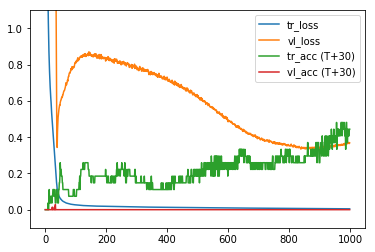

In [13]:
plt.plot(train_loss_hist, label="tr_loss")
plt.plot(test_loss_hist, label="vl_loss")
plt.plot(train_acc_hist, label="tr_acc (T+30)")
plt.plot(test_acc_hist, label="vl_acc (T+30)")
plt.ylim([-0.1, 1.1])
plt.legend(); plt.show()

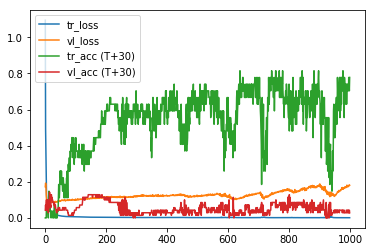

In [14]:
plt.plot(train_loss_hist, label="tr_loss")
plt.plot(test_loss_hist, label="vl_loss")
plt.plot(train_acc_hist, label="tr_acc (T+30)")
plt.plot(test_acc_hist, label="vl_acc (T+30)")
plt.legend(); plt.show()

In [13]:
# torch.save(model.state_dict(), "model/lstm-1_h4_1000epochs.pt")
model.load_state_dict(torch.load("model/lstm-1_h32_1000epochs.pt"))

torch.Size([10, 960, 14]) torch.Size([10, 30, 1])
torch.Size([10, 30, 1])
(10, 960, 14) (10, 30, 1) (10, 30, 1)


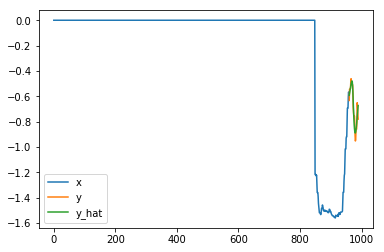

In [29]:
# 予測
train_loader = DataLoader(BalticDryIndexDataset(x_train, y_train), batch_size=10, shuffle=False)
x,y = iter(train_loader).next()
print(x.shape, y.shape)
output = model(x, l_pre=l_pre, l_post=l_post)
print(output.shape)

output = output.detach().numpy()
x = x.detach().numpy()
y = y.detach().numpy()
print(x.shape, y.shape, output.shape)

k = np.random.randint(len(x))
plt.plot(range(0, len(x[0])), x[k,:,0], label="x")
plt.plot(range(len(x[0]), len(x[0])+len(y[0])), y[k,:,0], label="y")
plt.plot(range(len(x[0]), len(x[0])+len(y[0])), output[k,:,0], label="y_hat")
plt.legend()
plt.show()

torch.Size([10, 960, 14]) torch.Size([10, 30, 1])
torch.Size([10, 30, 1])
(10, 960, 14) (10, 30, 1) (10, 30, 1)


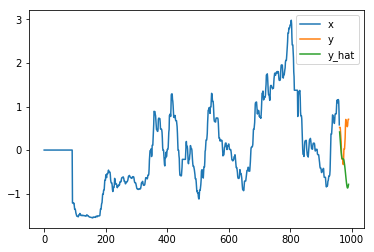

In [40]:
# 予測
test_loader = DataLoader(BalticDryIndexDataset(x_test, y_test), batch_size=10, shuffle=False)
x,y = iter(test_loader).next()
print(x.shape, y.shape)
output = model(x, l_pre=l_pre, l_post=l_post)
print(output.shape)

output = output.detach().numpy()
x = x.detach().numpy()
y = y.detach().numpy()
print(x.shape, y.shape, output.shape)

k = np.random.randint(len(x))
plt.plot(range(0, len(x[0])), x[k,:,0], label="x")
plt.plot(range(len(x[0]), len(x[0])+len(y[0])), y[k,:,0], label="y")
plt.plot(range(len(x[0]), len(x[0])+len(y[0])), output[k,:,0], label="y_hat")
plt.legend()
plt.show()

In [16]:
train_loader = DataLoader(BalticDryIndexDataset(x_train, y_train), batch_size=10, shuffle=True)
x,y = iter(train_loader).next()
print(x.shape, y.shape)
output = model(x, l_pre=l_pre, l_post=l_post)
print(output.shape)
np.abs((output[:,-1].data-y[:,-1].data).numpy()) < 0.1

torch.Size([10, 960, 14]) torch.Size([10, 30, 1])
torch.Size([10, 30, 1])


array([[ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [17]:
np.sum(np.abs((output[:,-1].data-y[:,-1].data).numpy()) < 0.1)

9